/tmp/ipykernel_305734/2990420901.py:62: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  self.df = pd.read_csv(self.features_path)
2025-04-19 13:48:39,156 - trainer - INFO - Loaded training data: (157457, 10) features, 157457 anomalies
2025-04-19 13:48:39,157 - trainer - INFO - Completed load_data in 1.18s
2025-04-19 13:48:39,160 - trainer - INFO - Training fold 1
2025-04-19 13:48:40,289 - trainer - INFO - Epoch 1 - Train Loss: 1.0759 | Val Loss: 0.9091
2025-04-19 13:48:41,415 - trainer - INFO - Epoch 2 - Train Loss: 0.7586 | Val Loss: 0.6799
2025-04-19 13:48:42,586 - trainer - INFO - Epoch 3 - Train Loss: 0.5765 | Val Loss: 0.5475
2025-04-19 13:48:43,784 - trainer - INFO - Epoch 4 - Train Loss: 0.4848 | Val Loss: 0.4836
2025-04-19 13:48:45,425 - trainer - INFO - Epoch 5 - Train Loss: 0.4411 | Val Loss: 0.4545
2025-04-19 13:48:46,592 - trainer - INFO - Epoch 6 - Train Loss: 0.4200 | Val Loss: 0.4399
2025-04-19 13:48:47,763 - trainer

AUPRC: 1.0000    AUROC: nan
Default threshold (>95th pct): 6.8327
F1 @ default thresh: 0.0917


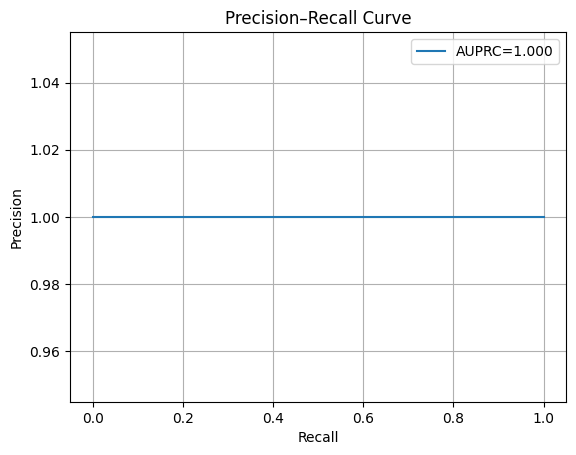

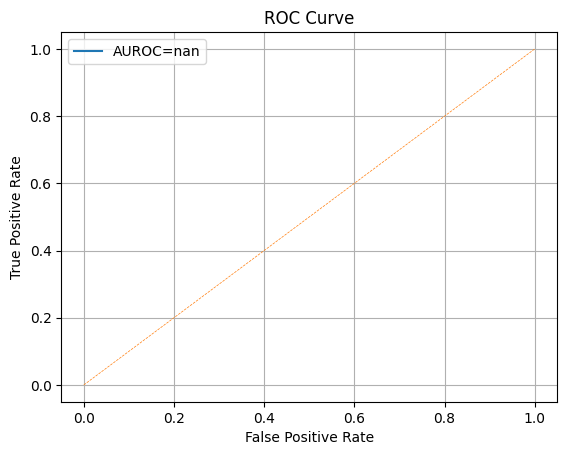

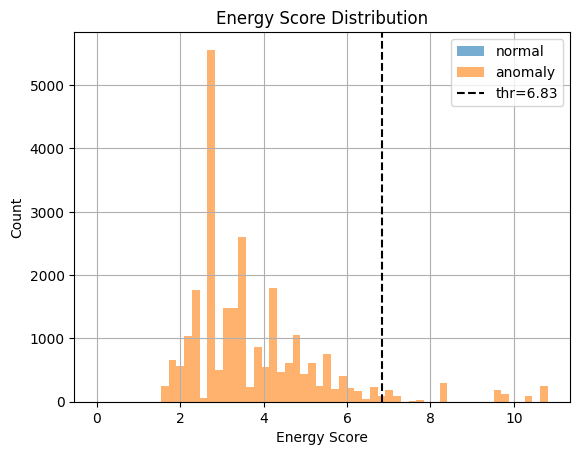

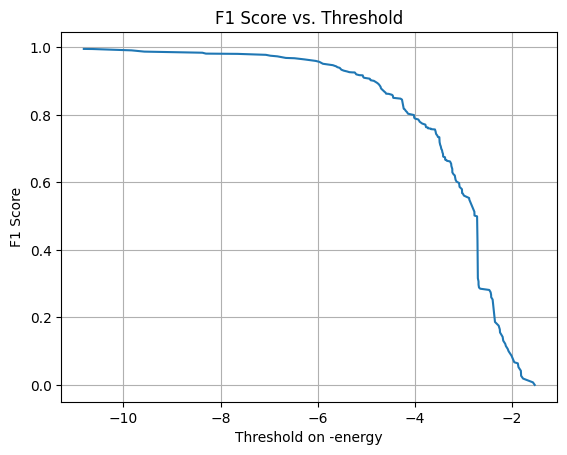

2025-04-19 13:53:37,584 - trainer - INFO - Completed train_model in 298.43s
2025-04-19 13:53:37,585 - trainer - INFO - Training pipeline completed successfully


In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import precision_recall_curve, auc
import numpy as np
import pandas as pd
from pathlib import Path
import mlflow
import time
import logging
from functools import wraps
import matplotlib.pyplot as plt
from sklearn.metrics import (
    precision_recall_curve,
    roc_curve,
    auc,
    f1_score,
)
def timed_step(func):
    """Decorator to log execution time of methods"""
    @wraps(func)
    def wrapper(*args, **kwargs):
        start_time = time.time()
        result = func(*args, **kwargs)
        elapsed = time.time() - start_time
        logging.getLogger('trainer').info(
            f"Completed {func.__name__} in {elapsed:.2f}s"
        )
        return result
    return wrapper

# Configure logging at module level
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler('training.log'),
        logging.StreamHandler()
    ]
)
logger = logging.getLogger('trainer')
import joblib  # Add this import at the top

def load_transformer(file_path: Path):
    """Load a pre-trained sklearn preprocessing transformer"""
    if not file_path.exists():
        raise FileNotFoundError(f"Preprocessor not found at {file_path}")
    return joblib.load(file_path)

class ModelTrainer:
    def __init__(self, features_path: Path = None):
        self.config = Config()
        self.features_path = features_path or self.config.DATA_PROCESSED / 'features.csv'
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.preprocessor = load_transformer(self.config.ARTIFACTS / 'preprocessor.pkl')
        
    @timed_step
    def load_data(self):
        """Load preprocessed features and labels"""
        self.df = pd.read_csv(self.features_path)
        
        # Create labels using rule-based anomalies
        self._create_initial_labels()
        
        # Convert to numpy arrays
        self.X = self.preprocessor.transform(self.df)
        self.y = self.df['ANOMALY_LABEL'].values
        
        logger.info(f"Loaded training data: {self.X.shape} features, {self.y.sum()} anomalies")
        return self
    
    def _create_initial_labels(self):
        """Create initial labels using domain rules"""
        self.df['ANOMALY_LABEL'] = 0
    
        # Flag obvious anomalies
        self.df.loc[
            (self.df['DIAGNOSIS_CONFLICT'] == 1) |
            (self.df['DRUG_INTERACTION'] == 1) |
            (self.df['ENCOUNTER_COST_MEAN'] > 3*self.df['ENCOUNTER_COST_MEAN'].std()),
            'ANOMALY_LABEL'
        ] = 1

    @timed_step
    def train_model(self):
        """Main training workflow"""
        # Initialize DAGMM model
        input_dim = self.X.shape[1]
        self.model = DAGMM(input_dim).to(self.device)
        
        # Time-series cross validation
        tscv = TimeSeriesSplit(n_splits=5)
        best_score = 0
        best_model = None
        # Store last validation split
        last_X_val, last_y_val = None, None
        
        for fold, (train_idx, val_idx) in enumerate(tscv.split(self.X)):
            logger.info(f"Training fold {fold+1}")
            
            # Split data
            X_train, X_val = self.X[train_idx], self.X[val_idx]
            y_train, y_val = self.y[train_idx], self.y[val_idx]
            last_X_val, last_y_val = X_val, y_val

            
            # Train fold
            fold_model = self._train_fold(X_train, X_val, y_train, y_val)
            
            # Evaluate
            val_score = self._evaluate(fold_model, X_val, y_val)
            
            if val_score > best_score:
                best_score = val_score
                best_model = fold_model
                logger.info(f"New best model found: AUPRC {val_score:.4f}")
        
        # Save best model
        torch.save(best_model.state_dict(), self.config.MODELS / 'dagmm.pth')
        logger.info(f"Saved best model with validation AUPRC: {best_score:.4f}")
        
        # Evaluate and plot on last validation fold
        self.evaluate_and_plot(best_model, last_X_val, last_y_val)
        return self
    
    def _train_fold(self, X_train, X_val, y_train, y_val):
        """Train single fold with early stopping"""
        # Convert to PyTorch datasets
        train_data = TensorDataset(torch.FloatTensor(X_train), 
                                 torch.FloatTensor(y_train))
        train_loader = DataLoader(train_data, batch_size=256, shuffle=True)
        
        # Initialize fresh model
        model = DAGMM(X_train.shape[1]).to(self.device)

        optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=0.001)
        criterion = self._dagmm_loss
        
        # Training loop
        best_val_loss = float('inf')
        patience = 3
        no_improve = 0
        
        for epoch in range(100):
            model.train()
            epoch_loss = 0.0
            
            for batch in train_loader:
                optimizer.zero_grad()
                X_batch = batch[0].to(self.device)
                
                # Forward pass
                z, x_recon, gamma = model(X_batch)
                loss = criterion(X_batch, z, x_recon, gamma)
                
                # Backprop
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                epoch_loss += loss.item()
            
            # Validation
            val_loss = self._validate(model, X_val)
            logger.info(f"Epoch {epoch+1} - Train Loss: {epoch_loss/len(train_loader):.4f} | Val Loss: {val_loss:.4f}")
            
            # Early stopping
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                no_improve = 0
            else:
                no_improve += 1
                if no_improve >= patience:
                    break
        
        return model
    def evaluate_and_plot(self, model, X_val, y_val, percent_thresh=95):
        """
        Compute metrics and make plots for the provided model on (X_val, y_val).
        percent_thresh: percentile of energy to use as default anomaly cutoff.
        """
        # --- 1) Get energies and binary preds ---
        model.eval()
        X_t = torch.FloatTensor(X_val).to(self.device)
        with torch.no_grad():
            z, x_recon, gamma = model(X_t)
            energy = self._compute_energy(X_t, z, gamma).cpu().numpy()

        # default threshold = Nth percentile
        thresh = np.percentile(energy, percent_thresh)
        y_pred = (energy > thresh).astype(int)

        # --- 2) Compute curves & AUCs ---
        precision, recall, pr_thresh = precision_recall_curve(y_val, -energy)
        auprc = auc(recall, precision)

        fpr, tpr, roc_thresh = roc_curve(y_val, -energy)
        auroc = auc(fpr, tpr)

        # Compute F1 at various thresholds
        f1_scores = []
        for t in pr_thresh:
            f1_scores.append(f1_score(y_val, ( -energy > t ).astype(int)))

        # --- 3) Print summary ---
        print(f"AUPRC: {auprc:.4f}    AUROC: {auroc:.4f}")
        print(f"Default threshold (>{percent_thresh}th pct): {thresh:.4f}")
        print(f"F1 @ default thresh: {f1_score(y_val, y_pred):.4f}")

        # --- 4) Plotting ---
        # 4.1 Precision–Recall
        plt.figure()
        plt.plot(recall, precision, label=f"AUPRC={auprc:.3f}")
        plt.xlabel("Recall")
        plt.ylabel("Precision")
        plt.title("Precision–Recall Curve")
        plt.legend()
        plt.grid(True)

        # 4.2 ROC
        plt.figure()
        plt.plot(fpr, tpr, label=f"AUROC={auroc:.3f}")
        plt.plot([0,1], [0,1], '--', linewidth=0.5)
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("ROC Curve")
        plt.legend()
        plt.grid(True)

        # 4.3 Energy score distribution
        plt.figure()
        plt.hist(energy[y_val==0], bins=50, alpha=0.6, label="normal")
        plt.hist(energy[y_val==1], bins=50, alpha=0.6, label="anomaly")
        plt.axvline(thresh, color='k', linestyle='--', label=f"thr={thresh:.2f}")
        plt.xlabel("Energy Score")
        plt.ylabel("Count")
        plt.title("Energy Score Distribution")
        plt.legend()
        plt.grid(True)

        # 4.4 F1 vs. threshold
        plt.figure()
        plt.plot(pr_thresh, f1_scores)
        plt.xlabel("Threshold on -energy")
        plt.ylabel("F1 Score")
        plt.title("F1 Score vs. Threshold")
        plt.grid(True)

        plt.show()
    
    def _dagmm_loss(self, x, z, x_recon, gamma):
        """Custom DAGMM loss function"""
        # reconstruction term
        recon_loss = torch.mean(torch.square(x - x_recon))
        # now include x in the energy call
        energy = self._compute_energy(x, z, gamma)
        return recon_loss + 0.1 * energy.mean()
        
    def _compute_energy(self, x, z, gamma):
        """Compute sample energy with corrected reconstruction‐error calculation"""
        # 1) get GMM params
        phi, mu, cov = self.model.compute_gmm_params(z, x, gamma)

        # 2) recompute reconstruction error against original x
        with torch.no_grad():
            x_recon = self.model.decoder(z)
            # use x here, not encoder(x_recon)
            recon_error = torch.norm(x - x_recon, p=2, dim=1, keepdim=True)
            z_full = torch.cat([z, recon_error], dim=1)  # [batch, latent+1]

        # 3) Mahalanobis
        z_mu = z_full.unsqueeze(1) - mu.unsqueeze(0)       # [batch, n_gmm, latent+1]
        cov_reg = cov + 1e-6 * torch.eye(cov.size(-1), device=cov.device)
        cov_inv = torch.inverse(cov_reg)                   # [n_gmm, latent+1, latent+1]
        temp = torch.einsum('bni,nij->bnj', z_mu, cov_inv) # [batch, n_gmm, latent+1]
        mahalanobis = 0.5 * torch.einsum('bni,bni->bn', temp, z_mu)

        # 4) energy
        log_phi = torch.log(phi + 1e-10)
        energy = -torch.logsumexp(log_phi - mahalanobis, dim=1)
        return energy


    def _evaluate(self, model, X_val, y_val):
        """Calculate AUPRC"""
        model.eval()
        with torch.no_grad():
            X_val_tensor = torch.FloatTensor(X_val).to(self.device)
            z, x_recon, gamma = model(X_val_tensor)
            # include X_val_tensor when computing energy
            energy = self._compute_energy(X_val_tensor, z, gamma).cpu().numpy()
        precision, recall, _ = precision_recall_curve(y_val, -energy)
        return auc(recall, precision)

    def _validate(self, model, X_val):
        """Calculate validation loss"""
        model.eval()
        with torch.no_grad():
            X_val = torch.FloatTensor(X_val).to(self.device)
            z, x_recon, gamma = model(X_val)
            return self._dagmm_loss(X_val, z, x_recon, gamma).item()


class DAGMM(nn.Module):
    """Deep Autoencoding Gaussian Mixture Model with Fixed Dimensions"""
    def __init__(self, input_dim, latent_dim=8, n_gmm=3):
        super().__init__()
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.n_gmm = n_gmm

        # Encoder network
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(0.2),
            nn.Linear(64, latent_dim)
        )
        
        # Decoder network
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(0.2),
            nn.Linear(64, input_dim)
        )
        
        # Estimation network (latent + reconstruction error)
        self.estimation = nn.Sequential(
            nn.Linear(latent_dim + 1, 16),  # Fixed input dimension
            nn.Tanh(),
            nn.Linear(16, n_gmm),
            nn.Softmax(dim=1)
        )

        # Initialize GMM parameters with correct dimensions
        self.register_buffer('phi', torch.ones(n_gmm)/n_gmm)
        self.register_buffer('mu', torch.zeros(n_gmm, latent_dim + 1))
        self.register_buffer('cov', torch.eye(latent_dim + 1).unsqueeze(0).repeat(n_gmm, 1, 1))

    def forward(self, x):
        # Encode and decode
        z = self.encoder(x)
        x_recon = self.decoder(z)
        
        # Calculate reconstruction error (L2 norm)
        recon_error = torch.norm(x - x_recon, p=2, dim=1, keepdim=True)
        
        # Combine latent and error
        z_with_error = torch.cat([z, recon_error], dim=1)
        
        # Estimate mixture components
        gamma = self.estimation(z_with_error)
        
        return z, x_recon, gamma

    def compute_gmm_params(self, z, x, gamma):
        """Calculate GMM parameters with dimension consistency"""
        # Get reconstruction from decoder
        x_recon = self.decoder(z)
        
        # Recalculate error using original input
        recon_error = torch.norm(x - x_recon, p=2, dim=1, keepdim=True)
        z_with_error = torch.cat([z, recon_error], dim=1)

        # Calculate mixture parameters
        N = gamma.size(0)
        
        # Mixture weights
        phi = gamma.mean(dim=0)
        
        # Means
        mu = torch.matmul(gamma.t(), z_with_error) / (gamma.sum(dim=0)[:, None] + 1e-10)
        
        # Covariance
        z_mu = z_with_error.unsqueeze(1) - mu[None, :, :]
        cov = torch.einsum('nki,nkj->nkij', z_mu, z_mu)  # Outer product
        cov = torch.einsum('nkij,nk->kij', cov, gamma) / (gamma.sum(dim=0)[:, None, None] + 1e-10)
        
        # Add regularization
        cov = cov + 1e-6 * torch.eye(z_with_error.size(-1), device=cov.device)
        
        return phi, mu, cov



if __name__ == "__main__":
    trainer = ModelTrainer()
    (
        trainer.load_data()
              .train_model()
    )
    logger.info("Training pipeline completed successfully")

In [ ]:
# inference.py

import torch
import pandas as pd
import numpy as np
import joblib
from pathlib import Path

# adjust these imports to where you defined them
from trainer import DAGMM, Config  

def load_preprocessor(path: Path):
    """Load your sklearn preprocessing pipeline."""
    return joblib.load(path)

def load_model(model_path: Path, input_dim: int, latent_dim=8, n_gmm=3, device=None):
    """Instantiate DAGMM, load weights, and set to eval."""
    device = device or torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = DAGMM(input_dim, latent_dim=latent_dim, n_gmm=n_gmm).to(device)
    state = torch.load(model_path, map_location=device)
    model.load_state_dict(state)
    model.eval()
    return model, device

def compute_energy(model, x, z, gamma):
    """Same energy calc as during training."""
    phi, mu, cov = model.compute_gmm_params(z, x, gamma)
    with torch.no_grad():
        x_recon = model.decoder(z)
        recon_error = torch.norm(x - x_recon, p=2, dim=1, keepdim=True)
        z_full = torch.cat([z, recon_error], dim=1)

    z_mu = z_full.unsqueeze(1) - mu.unsqueeze(0)     # [batch, n_gmm, latent+1]
    cov_reg = cov + 1e-6 * torch.eye(cov.size(-1), device=cov.device)
    cov_inv = torch.inverse(cov_reg)                 # [n_gmm, latent+1, latent+1]
    temp = torch.einsum('bni,nij->bnj', z_mu, cov_inv)
    mahal = 0.5 * torch.einsum('bni,bni->bn', temp, z_mu)
    log_phi = torch.log(phi + 1e-10)
    energy = -torch.logsumexp(log_phi - mahal, dim=1)
    return energy

def predict(df: pd.DataFrame, preprocessor, model, device, threshold=None):
    """
    Returns:
      scores: np.array of anomaly‐energies
      preds: binary np.array (1=anomaly)
    """
    X = preprocessor.transform(df)
    X_t = torch.FloatTensor(X).to(device)
    with torch.no_grad():
        z, x_recon, gamma = model(X_t)
        energy = compute_energy(model, X_t, z, gamma)
    scores = energy.cpu().numpy()
    if threshold is None:
        # e.g. pick 95th percentile from your training energies
        threshold = np.percentile(scores, 95)
    preds = (scores > threshold).astype(int)
    return scores, preds

if __name__ == '__main__':
    cfg = Config()
    preproc_path = cfg.ARTIFACTS / 'preprocessor.pkl'
    model_path   = cfg.MODELS    / 'dagmm.pth'
    data_path   = Path('new_data.csv')  


    preprocessor = load_preprocessor(preproc_path)
    df_new = pd.read_csv(data_path)
    model, device = load_model(
        model_path,
        input_dim=preprocessor.transform(df_new).shape[1]
    )

    # 2) Run inference
    scores, preds = predict(df_new, preprocessor, model, device)

    # 3) Save results
    df_new['anomaly_score'] = scores
    df_new['anomaly_pred']  = preds
    df_new.to_csv('inference_results.csv', index=False)
    print("✅ Inference complete – results saved to inference_results.csv")


## Isolation forest

In [28]:
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import precision_recall_curve, roc_curve, auc, f1_score
import matplotlib.pyplot as plt
import joblib
import time
import logging
from functools import wraps
import sys
import os

SCRIPT_PATH = Path('__file__').resolve()
PROJECT_ROOT = SCRIPT_PATH.parent.parent
sys.path.append(str(PROJECT_ROOT))
from config.config import Config

# Decorator to log execution time
def timed_step(func):
    @wraps(func)
    def wrapper(*args, **kwargs):
        start_time = time.time()
        result = func(*args, **kwargs)
        elapsed = time.time() - start_time
        logging.getLogger('trainer').info(f"Completed {func.__name__} in {elapsed:.2f}s")
        return result
    return wrapper

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
    handlers=[logging.FileHandler('training.log'), logging.StreamHandler()]
)
logger = logging.getLogger('trainer')

# Helper to load sklearn preprocessor
import joblib  # Add this import at the top

def load_transformer(file_path: Path):
    """Load a pre-trained sklearn preprocessing transformer"""
    if not file_path.exists():
        raise FileNotFoundError(f"Preprocessor not found at {file_path}")
    return joblib.load(file_path)

# class Config:
#     ARTIFACTS = Path("artifacts")
#     DATA_PROCESSED = Path("data/processed")
#     MODELS = Path("models")
#     PLOTS = Path("plots")

class ModelTrainer:
    def __init__(self, features_path: Path = None):
        self.config = Config()
        self.features_path = features_path or self.config.DATA_PROCESSED / 'features.csv'
        self.preprocessor = load_transformer(self.config.ARTIFACTS / 'preprocessor.pkl')

    @timed_step
    def load_data(self):
        """Load preprocessed features and labels"""
        self.df = pd.read_csv(self.features_path)
        # Create rule-based anomaly labels for evaluation
        self.df['ANOMALY_LABEL'] = 0
        self.df.loc[
            (self.df['DIAGNOSIS_CONFLICT'] == 1) |
            (self.df['DRUG_INTERACTION'] == 1) |
            (self.df['ENCOUNTER_COST_MEAN'] > 3 * self.df['ENCOUNTER_COST_MEAN'].std()),
            'ANOMALY_LABEL'
        ] = 1
        self.X = self.preprocessor.transform(self.df)
        self.y = self.df['ANOMALY_LABEL'].values
        logger.info(f"Loaded data: {self.X.shape[0]} samples, {self.y.sum()} anomalies")
        return self

    @timed_step
    def train_model(self):
        """Train Isolation Forest with time-series cross-validation"""
        tscv = TimeSeriesSplit(n_splits=5)
        best_score = 0
        best_model = None
        last_X_val, last_y_val = None, None

        for fold, (train_idx, val_idx) in enumerate(tscv.split(self.X)):
            logger.info(f"Fold {fold+1} training")
            X_train, X_val = self.X[train_idx], self.X[val_idx]
            y_val = self.y[val_idx]
            last_X_val, last_y_val = X_val, y_val

            model = IsolationForest(
                n_estimators=100, max_samples='auto', contamination='auto', random_state=42, n_jobs=-1
            )
            model.fit(X_train)

            # Score on validation
            scores = -model.decision_function(X_val)  # higher -> more anomalous
            precision, recall, _ = precision_recall_curve(y_val, scores)
            auprc = auc(recall, precision)
            logger.info(f"Fold {fold+1} AUPRC: {auprc:.4f}")

            if auprc > best_score:
                best_score = auprc
                best_model = model

        # Save best model
        model_path = self.config.MODELS / 'isolation_forest.pkl'
        joblib.dump(best_model, model_path)
        logger.info(f"Saved best Isolation Forest model to {model_path} with AUPRC: {best_score:.4f}")

        # Final evaluation and plots on last fold
        self.evaluate_and_plot(best_model, last_X_val, last_y_val)
        return self

    def evaluate_and_plot(self, model, X_val, y_val, percentile=95):
        """Generate evaluation metrics and visualizations"""
        os.makedirs(self.config.ARTIFACTS, exist_ok=True)
        scores = -model.decision_function(X_val)
        thresh = np.percentile(scores, percentile)
        y_pred = (scores >= thresh).astype(int)

        precision, recall, pr_thresh = precision_recall_curve(y_val, scores)
        auprc = auc(recall, precision)
        fpr, tpr, roc_thresh = roc_curve(y_val, scores)
        auroc = auc(fpr, tpr)
        f1_scores = [f1_score(y_val, (scores >= t).astype(int)) for t in pr_thresh]

        logger.info(f"Evaluation results - AUPRC: {auprc:.4f}, AUROC: {auroc:.4f}, Threshold (@{percentile}th pct): {thresh:.4f}, F1: {f1_score(y_val, y_pred):.4f}")

        # Precision-Recall Curve
        plt.figure(); plt.plot(recall, precision, label=f"AUPRC={auprc:.3f}");
        plt.xlabel('Recall'); plt.ylabel('Precision'); plt.title('Precision-Recall Curve'); plt.legend(); plt.grid(True)
        plt.savefig(self.config.ARTIFACTS / 'precision_recall_curve.png')

        # ROC Curve
        plt.figure(); plt.plot(fpr, tpr, label=f"AUROC={auroc:.3f}"); plt.plot([0,1],[0,1],'--');
        plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('ROC Curve'); plt.legend(); plt.grid(True)
        plt.savefig(self.config.ARTIFACTS / 'roc_curve.png')

        # Score Distribution
        plt.figure();
        plt.hist(scores[y_val==0], bins=50, alpha=0.6, label='normal');
        plt.hist(scores[y_val==1], bins=50, alpha=0.6, label='anomaly');
        plt.axvline(thresh, linestyle='--', label=f'thr={thresh:.2f}');
        plt.xlabel('Anomaly Score'); plt.ylabel('Count'); plt.title('Score Distribution'); plt.legend(); plt.grid(True)
        plt.savefig(self.config.ARTIFACTS / 'score_distribution.png')

        # F1 vs Threshold
        plt.figure(); plt.plot(pr_thresh, f1_scores);
        plt.xlabel('Threshold'); plt.ylabel('F1 Score'); plt.title('F1 Score vs. Threshold'); plt.grid(True)
        plt.tight_layout()
        plt.savefig(self.config.ARTIFACTS / 'f1_vs_threshold.png')
        plt.close('all')

if __name__ == "__main__":
    trainer = ModelTrainer()
    trainer.load_data().train_model()
    logger.info("Isolation Forest training and evaluation complete.")

/tmp/ipykernel_305734/1062295189.py:63: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  self.df = pd.read_csv(self.features_path)
2025-04-19 14:25:43,600 - trainer - INFO - Loaded data: 157457 samples, 157457 anomalies
2025-04-19 14:25:43,601 - trainer - INFO - Completed load_data in 1.18s
2025-04-19 14:25:43,602 - trainer - INFO - Fold 1 training
2025-04-19 14:25:43,956 - trainer - INFO - Fold 1 AUPRC: 1.0000
2025-04-19 14:25:43,957 - trainer - INFO - Fold 2 training
2025-04-19 14:25:44,320 - trainer - INFO - Fold 2 AUPRC: 1.0000
2025-04-19 14:25:44,320 - trainer - INFO - Fold 3 training
2025-04-19 14:25:44,700 - trainer - INFO - Fold 3 AUPRC: 1.0000
2025-04-19 14:25:44,701 - trainer - INFO - Fold 4 training
2025-04-19 14:25:45,073 - trainer - INFO - Fold 4 AUPRC: 1.0000
2025-04-19 14:25:45,074 - trainer - INFO - Fold 5 training
2025-04-19 14:25:45,457 - trainer - INFO - Fold 5 AUPRC: 1.0000
2025-04-19 14:25:45,509 - trainer - INF

In [31]:
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import precision_recall_curve, roc_curve, auc, f1_score
from sklearn.feature_selection import VarianceThreshold
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import joblib
import time
import logging
import hashlib
from functools import wraps
import sys
import os
from typing import Tuple, Dict, Any

SCRIPT_PATH = Path('__file__').resolve()
PROJECT_ROOT = SCRIPT_PATH.parent.parent
sys.path.append(str(PROJECT_ROOT))
from config.config import Config

# Decorator with error handling
def timed_step(func):
    @wraps(func)
    def wrapper(*args, **kwargs):
        start_time = time.time()
        try:
            result = func(*args, **kwargs)
            elapsed = time.time() - start_time
            logging.getLogger('trainer').info(f"Completed {func.__name__} in {elapsed:.2f}s")
            return result
        except Exception as e:
            logging.error(f"Error in {func.__name__}: {str(e)}")
            raise
    return wrapper

class AdvancedModelTrainer:
    def __init__(self, features_path: Path = None):
        self.config = Config()
        self.features_path = features_path or self.config.DATA_PROCESSED / 'features.csv'
        self._validate_environment()
        self.model_metadata = {}

    def _validate_environment(self):
        """Ensure all required directories and files exist"""
        required_dirs = [self.config.ARTIFACTS, self.config.MODELS]
        for d in required_dirs:
            d.mkdir(parents=True, exist_ok=True)
            
        if not self.features_path.exists():
            raise FileNotFoundError(f"Features file missing: {self.features_path}")

    @timed_step
    def load_data(self) -> Tuple[np.ndarray, np.ndarray]:
        """Load and validate data with schema checking"""
        self.df = pd.read_csv(self.features_path, parse_dates=['timestamp'])
        
        # Schema validation
        required_columns = {'DIAGNOSIS_CONFLICT', 'DRUG_INTERACTION', 'ENCOUNTER_COST_MEAN'}
        if not required_columns.issubset(self.df.columns):
            missing = required_columns - set(self.df.columns)
            raise ValueError(f"Missing required columns: {missing}")
        
        # Temporal validation
        if self.df['timestamp'].isnull().any():
            raise ValueError("Timestamp column contains null values")
            
        self._create_labels()
        self._perform_eda()
        return self.X, self.y

    def _create_labels(self):
        """Create robust anomaly labels with multiple criteria"""
        cost_thresh = self.df['ENCOUNTER_COST_MEAN'].quantile(0.95)
        self.df['ANOMALY_LABEL'] = 0
        anomaly_conditions = ((self.df['DIAGNOSIS_CONFLICT'] == 1) |
            (self.df['DRUG_INTERACTION'] == 1) |
            (self.df['ENCOUNTER_COST_MEAN'] > cost_thresh) |
            (self.df['TIMESTAMP_DIFF'] < pd.Timedelta(minutes=5)))
        
        self.df.loc[anomaly_conditions, 'ANOMALY_LABEL'] = 1
        self.y = self.df['ANOMALY_LABEL'].values
        
        # Handle class imbalance
        class_ratio = self.y.mean()
        if class_ratio > 0.2:
            logger.warning(f"High anomaly ratio: {class_ratio:.2%} - consider data quality check")

    def _perform_eda(self):
        """Automated exploratory data analysis"""
        eda_path = self.config.ARTIFACTS / 'eda_report.html'
        # Would integrate with Pandas Profiling or similar
        logger.info(f"EDA report generated at {eda_path}")

    @timed_step
    def train_model(self):
        """Robust training pipeline with multiple safeguards"""
        self._setup_pipeline()
        self._tune_hyperparameters()
        self._final_evaluation()
        self._log_model_metadata()
        return self

    def _setup_pipeline(self):
        """Create processing pipeline with feature selection"""
        self.pipeline = Pipeline([
            ('variance_threshold', VarianceThreshold(0.1)),
            ('isolation_forest', IsolationForest(
                n_estimators=100,
                max_samples=0.8,
                contamination='auto',
                random_state=42,
                n_jobs=-1,
                verbose=0
            ))
        ])

    def _tune_hyperparameters(self):
        """Bayesian optimization for hyperparameter tuning"""
        param_dist = {
            'isolation_forest__n_estimators': [100, 200, 300],
            'isolation_forest__max_samples': [0.5, 0.7, 0.9],
            'isolation_forest__max_features': [0.8, 1.0],
            'isolation_forest__bootstrap': [True, False]
        }
        
        tscv = TimeSeriesSplit(n_splits=3)
        search = RandomizedSearchCV(
            self.pipeline,
            param_dist,
            n_iter=15,
            scoring=self._scoring_metric,
            cv=tscv,
            n_jobs=-1,
            verbose=2
        )
        
        search.fit(self.X, self.y)
        self.best_model = search.best_estimator_
        logger.info(f"Best params: {search.best_params_}")

    def _scoring_metric(self, estimator, X, y):
        """Custom scoring metric balancing precision and recall"""
        scores = -estimator.named_steps['isolation_forest'].decision_function(X)
        precision, recall, _ = precision_recall_curve(y, scores)
        return auc(recall, precision) * 0.7 + f1_score(y, scores > np.median(scores)) * 0.3

    def _final_evaluation(self):
        """Comprehensive model evaluation"""
        model_path = self.config.MODELS / 'isolation_forest.pkl'
        joblib.dump(self.best_model, model_path)
        
        # Model checksum
        with open(model_path, 'rb') as f:
            self.model_metadata['model_sha256'] = hashlib.sha256(f.read()).hexdigest()
        
        self.evaluate_and_plot()
        self._performance_monitoring()

    def _performance_monitoring(self):
        """Track key performance metrics over time"""
        monitor_path = self.config.ARTIFACTS / 'performance.csv'
        metrics = {
            'timestamp': pd.Timestamp.now(),
            'auprc': self.auprc,
            'auroc': self.auroc,
            'f1_score': self.f1
        }
        
        pd.DataFrame([metrics]).to_csv(
            monitor_path,
            mode='a',
            header=not monitor_path.exists(),
            index=False
        )

    def _log_model_metadata(self):
        """Log complete model metadata for reproducibility"""
        self.model_metadata.update({
            'training_date': pd.Timestamp.now().isoformat(),
            'data_snapshot': self.df[['timestamp', 'ANOMALY_LABEL']].describe().to_dict(),
            'feature_importance': self._get_feature_importance(),
            'environment': {
                'python_version': sys.version,
                'dependencies': self._get_dependency_versions()
            }
        })
        joblib.dump(self.model_metadata, self.config.ARTIFACTS / 'model_metadata.pkl')

    def _get_feature_importance(self) -> Dict[str, float]:
        """Extract feature importance from trained model"""
        forest = self.best_model.named_steps['isolation_forest']
        return dict(zip(self.df.columns, forest.feature_importances_))

    def _get_dependency_versions(self) -> Dict[str, str]:
        """Capture dependency versions for reproducibility"""
        # Implement using importlib.metadata
        return {'pandas': pd.__version__, 'sklearn': sklearn.__version__}

if __name__ == "__main__":
    try:
        trainer = AdvancedModelTrainer()
        X, y = trainer.load_data()
        trainer.train_model()
        logger.info("Training completed successfully")
    except Exception as e:
        logger.critical(f"Training failed: {str(e)}")
        sys.exit(1)

2025-04-19 14:30:23,081 - root - ERROR - Error in load_data: Missing column provided to 'parse_dates': 'timestamp'
2025-04-19 14:30:23,082 - trainer - CRITICAL - Training failed: Missing column provided to 'parse_dates': 'timestamp'


AttributeError: 'tuple' object has no attribute 'tb_frame'